# Принятие решений в бизнесе

В данном проекте речь пойдет о крупном интернет-магазине. Совместно с отделом маркетинга мы подготовили список гипотез для увеличения выручки.

**Цели исследования:**

1. Приоритизировать гипотезы
2. Проанализировать результаты А/В-теста.


**Ход исследования**

Данные о гипотезах, заказах и пользователях возьмем из файлов `/datasets/hypothesis.csv`,`/datasets/orders.csv` и `/datasets/visitors.csv`.О качестве данных ничего неизвестно. Поэтому, перед тем как перейти к исследованию, необходимо будет провести обзор данных.


Структура `/datasets/hypothesis.csv`:

- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Структура `/datasets/orders.csv.`:


- `transactionId` — идентификатор заказа;
- `visitorId` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Структура `/datasets/visitors.csv.`: 


- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

Наше исследование разделено на три части, в каждой из которых будет определенное количество этапов:

**Часть 1. Обзор и предобработка данных:**

- Загрузка и обзор данных;
- Предобработка данных;

**Часть 2. Приоритизация гипотез:**

- Применение фреймворков ICE и RICE для приоритизации гипотез;
- Выводы по результатам приоритизации.

**Часть 3. Анализ А/В-теста:**

- Общий обзор на данные;
- Применение кумулятивных методов;
- Количество заказов на пользователя;
- Сумма чеков на пользователя;
- Вычисление статистической значимости.

**Общий вывод.**

## Обзор и предобработка данных.

### Загрузка и обзор данных

Загрузим данные, изучим и выполним предобработку.

In [1]:
#импорт библиотек

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as dt
import scipy.stats as stats

In [2]:
# загружаем файлы.

try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv', sep='\t')
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
    
try:
    orders = pd.read_csv('/datasets/orders.csv', sep='\t')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    
try:
    visitors = pd.read_csv('/datasets/visitors.csv', sep='\t')
except:
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

In [3]:
# сразу уберем предел отображения строк, чтобы видеть полное описание гипотез

pd.set_option('display.max_colwidth', None)

#посмотрим на содержание файлов

display(hypothesis.head(10),orders.head(5),visitors.head(5))

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


### Предобработка данных

Приведем столбцы к нижнему регистру, переименуем там, где это небходимо, поменяем тип данных.

In [4]:
hypothesis.columns = hypothesis.columns.str.lower()

orders = orders.rename(
    columns={
        'transactionId' : 'transaction_id',
        'visitorId' : 'visitor_id',              
    }
)

orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

Проверим результат, а заодно проведем обзор данных медотом `info()`

In [5]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [7]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Хотя после просмотра файлов методом `info()` мы видим, что количество строк во всех столбцах датафреймов одинаково, все равно пройдемся методом `isna()`

In [8]:
display(hypothesis.isna().sum(), orders.isna().sum(), visitors.isna().sum())

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

date        0
group       0
visitors    0
dtype: int64

Проверим наличие явных дубликатов

In [46]:
print('Количество дубликатов в hypothesis:', hypothesis.duplicated().sum())
print('Количество дубликатов в orders:', orders.duplicated().sum())
print('Количество дубликатов в visitors:', visitors.duplicated().sum())

Количество дубликатов в hypothesis: 0
Количество дубликатов в orders: 0
Количество дубликатов в visitors: 0


Теперь с данными все впорядке. Перейдем ко второй части исследования.

## Приоритизация гипотез.

Проанализируем список гипотез для увеличения выручки, подготовленный совместно с отделом маркетинга.


### Применим фреймвор *ICE* для приоритизации гипотез.

In [10]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
ice_score = hypothesis[['hypothesis','ice']].sort_values(by='ice', ascending=False).style.background_gradient(
    cmap=sns.light_palette('red', as_cmap=True)).format({'ice': lambda x: f'{x:.2f}'}) 
ice_score

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Примем во внимание первые 5 гипотез. Далее слишком большой разрыв. Посмотрим на результаты метода RICE.

### Применим фреймвор *RICE* для приоритизации гипотез.

In [11]:
hypothesis['rice'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
rice_score = hypothesis[['hypothesis','rice']].sort_values(by='rice', ascending=False).style.background_gradient(
    cmap=sns.light_palette('red', as_cmap=True)).format({'rice': lambda x: f'{x:.2f}'}) 
rice_score

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.00


**Вывод:**


Если взять также топ-5 гипотез, то мы увидим те же гипотезы, которые выделил метод ICE (0, 2, 6, 7, 8).
Звучат они следующим образом:
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Запустить акцию, дающую скидку на товар в день рождения

Эти гипотезы имеют средние или небольшие затраты для проверки, хорошее влияние на пользователей, их опыт и удовлетворение от продукта. Либо мы имеем высокую уверенность, что эти изменения повлияют на пользователей именно так, как мы предполагаем.


На количественную оценку метода RICE значительно повлиял параметр `reach`, т.е. пользовательский охват. А потому смотрим на место гипотезы среди остальных, а не на абсолютную оценку. Не столь важно, какой метод применять - главное оценивать его параметры.

Отталкиваясь от результатов второй части, думаю, первой для проверки можем выбрать гипотезу 0: "добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей".



## Анализ А/В-теста.

### Общий обзор на данные.

Посмотрим, как долго длился сам тест.

In [12]:
max_date = visitors['date'].max()
min_date = visitors['date'].min()

diff = max_date - min_date
diff

Timedelta('30 days 00:00:00')

Тест длился 30 дней. Посмотрим на количество пользователей в каждой группе.

In [97]:
print('Количество пользователей:', visitors['visitors'].sum())

visitors.groupby('group').agg({'visitors': 'sum'}).value_counts(normalize=True).reset_index()

Количество пользователей: 37652


,visitors,0
0,18736,0.5
1,18916,0.5


Выборка не маленькая - 37,6 тысяч пользователей. Соотношение по группам практически 50 на 50. 

Посмотрим на данные о покупателях.

In [49]:
orders_inf = (
    orders.groupby('group', as_index=False)
    .agg({'visitor_id': 'count', 'revenue': 'sum'})
)


# средняя выручка на пользователя


orders_inf['revenue_to_visitors_ratio'] = (
    orders_inf['revenue'] / orders_inf['visitor_id']
).map(lambda x: "{0:.2f}".format(x))

orders_inf

,group,visitor_id,revenue,revenue_to_visitors_ratio
0,A,557,4084803,7333.58
1,B,640,5907760,9230.88


In [116]:
# проверим, есть ли пользователи, которые попали в обе группы.

tgroups = orders.groupby('visitor_id').agg({'group': 'nunique'})
tgroups = tgroups.query("group > 1").count()

print('Пользователей, попавших в две группы:', tgroups[0])

Пользователей, попавших в две группы: 58


In [134]:
a = round((orders_inf['visitor_id'][0] / orders_inf['visitor_id'].sum() * 100),2)
b = round((orders_inf['visitor_id'][1] / orders_inf['visitor_id'].sum() * 100),2)

print('Доля заказов группы А:', a ,'%')
print('Доля заказов группы B:', b, '%')
print('Относительное различие количества заказов:', round((1-a/b)*100,2),'%')

Доля заказов группы А: 46.53 %
Доля заказов группы B: 53.47 %
Относительное различие количества заказов: 12.98 %


При этом относительное различие количества заказов - почти 13% (без поправки на уникальность пользователей). По выручке у группы В показатели также лучше. 


Так ли все хорошо на самом деле у группы В, выясним в дальнейшем исследовании.

### Кумулятивные методы

Чтобы построить графики, нужно собрать кумулятивные данные. Объявим датафрейм `cumulative_data` со столбцами: 
- `date` — дата;
- `group` — группа A/B-теста (A или B);
- `orders` — кумулятивное количество заказов на указанную дату в указанной группе;
- `buyers` — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- `revenue` — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- `visitors` — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [18]:
# создаем массив уникальных пар значений дат и групп теста

dates_groups = orders[['date','group']].drop_duplicates()
dates_groups.head(5)

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


In [135]:
# получаем агрегированные кумулятивные по дням данные о заказах 

orders_aggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

orders_aggregated.head(5)


,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [20]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 

visitors_aggregated = dates_groups.apply(  
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

visitors_aggregated.head(5)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [136]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия

cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [144]:
#проверим, корректно ли был создан датафрейм. 
#выведем информацию о датах, которую мы проверяли ранее и из датафрейма cumulative_data

print('Минимальная дата в visitors:', min_date)
print('Минимальная дата в cumulative_data:', cumulative_data['date'].min())
print()
print('Максимальная дата в visitors:', max_date)
print('Максимальная дата в cumulative_data:', cumulative_data['date'].max())

Минимальная дата в visitors: 2019-08-01 00:00:00
Минимальная дата в cumulative_data: 2019-08-01 00:00:00

Максимальная дата в visitors: 2019-08-31 00:00:00
Максимальная дата в cumulative_data: 2019-08-31 00:00:00


Мы собрали все нужные кумулятивные данные, можем перейти к построению графиков.

#### Кумулятивная выручка по группам. 

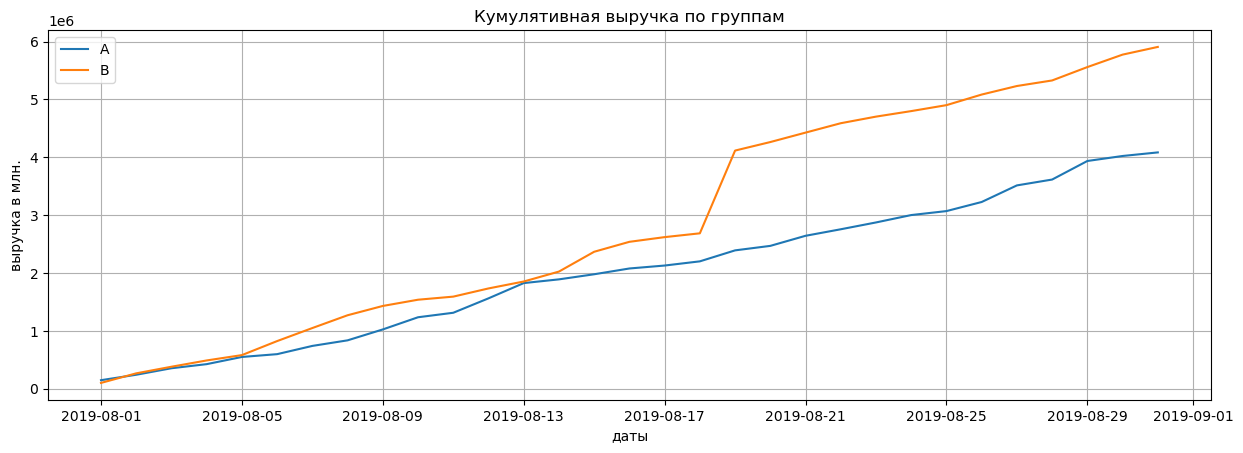

In [23]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А

cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B

cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А

plt.figure().set_figwidth(15)
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')

# Строим график выручки группы B

plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')

plt.legend() 
plt.grid()
plt.title('Кумулятивная выручка по группам')
plt.xlabel('даты')
plt.ylabel('выручка в млн.')
plt.show()

**Вывод:** выручка почти равонмерно увеличивается в течение всего теста - это хороший знак.
Обе группы шли практически одинаково, однако график выручки группы В в районе 18-го августа делает резкий скачок роста и продолжает лидировать остаток теста. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов.

#### Кумулятивное среднее чека по группам.

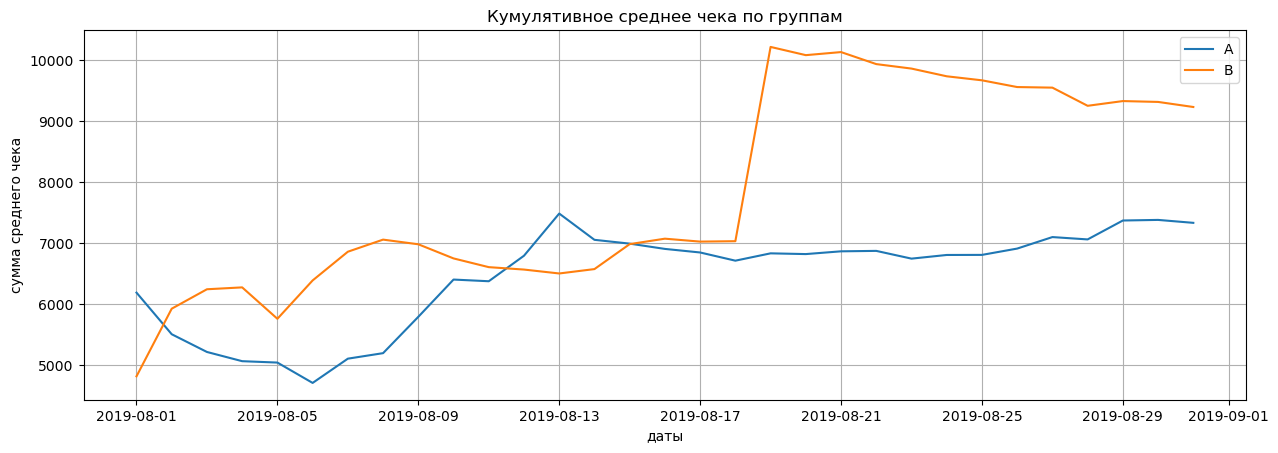

In [24]:
plt.figure().set_figwidth(15)
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], label='B')
plt.legend() 
plt.grid()
plt.title('Кумулятивное среднее чека по группам')
plt.xlabel('даты')
plt.ylabel('сумма среднего чека')
plt.show()

**Вывод:** похоже кумулятивное значение среднего чека группы А с середины теста зафиксировалось. В группе В видим резкий скачок роста также в районе 18-го августа, это может говорить о том, что в группу В 18-го августа попали крупные заказы. В таком случае, группе В нужно больше данных чтобы прийти к реальному среднему чеку и зафиксироваться на его уровне.


#### Относительное изменение кумулятивного среднего чека группы B к группе A.

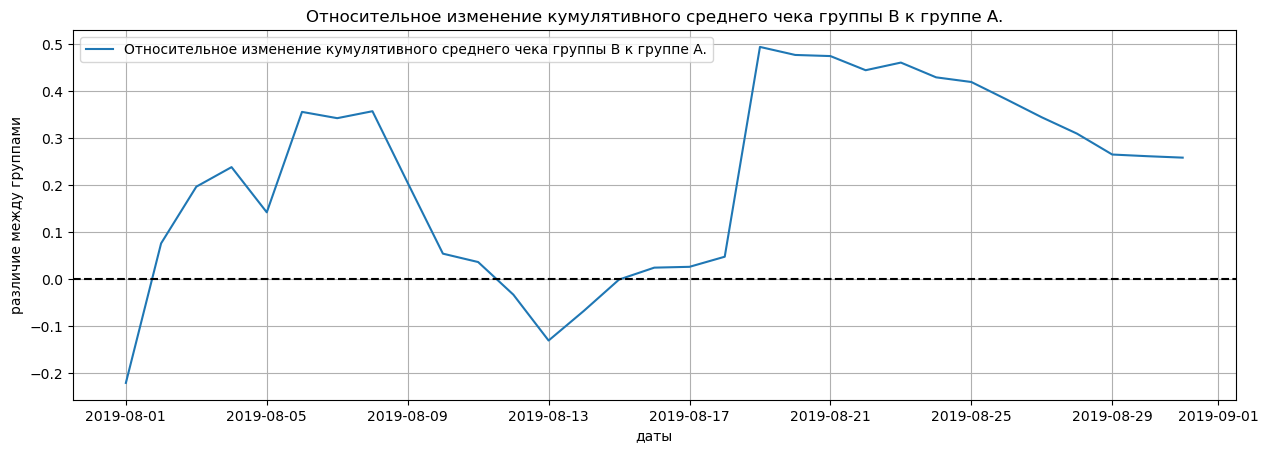

In [25]:
# собираем данные в одном датафрейме

merged_cumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, left_on='date', right_on='date', how='left', suffixes=['_A', '_B'])

# cтроим отношение средних чеков

plt.figure().set_figwidth(15)
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenue_B']/merged_cumulative_revenue['orders_B'])/(merged_cumulative_revenue['revenue_A']/merged_cumulative_revenue['orders_A'])-1, label="Относительное изменение кумулятивного среднего чека группы B к группе A.")
plt.legend()

# добавляем ось X

plt.axhline(y=0, color='black', linestyle='--')
plt.grid()
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A.')
plt.ylabel('различие между группами')
plt.xlabel('даты')
plt.show()

**Вывод:** в нескольких точках график различия между сегментами резко скачет, график не стабилизирован. Где-то уж точно спрятались крупные заказы и выбросы.

#### Кумулятивное среднее количества заказов на посетителя по группам

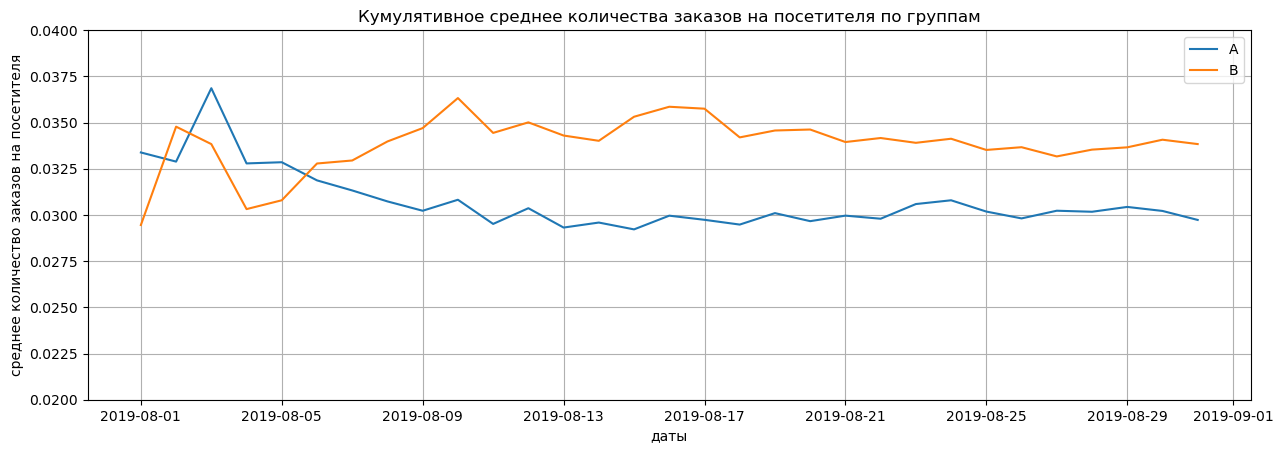

In [26]:
# считаем кумулятивное среднее количества заказов

cumulative_data['mean_orders'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A

cumulative_data_A = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B

cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

# строим графики

plt.figure().set_figwidth(15)
plt.plot(cumulative_data_A['date'], cumulative_data_A['mean_orders'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['mean_orders'], label='B')
plt.legend()
plt.grid()
plt.title('Кумулятивное среднее количества заказов на посетителя по группам')
plt.xlabel('даты')
plt.ylabel('среднее количество заказов на посетителя')

# задаем масштаб осей


plt.ylim(0.02,0.04)
plt.show()


**Вывод:** в начале теста наблюдались небольшие колебания, но график довольно быстро выровнялся. Пользователи группы В лидируют по данному показателю.

#### Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A.

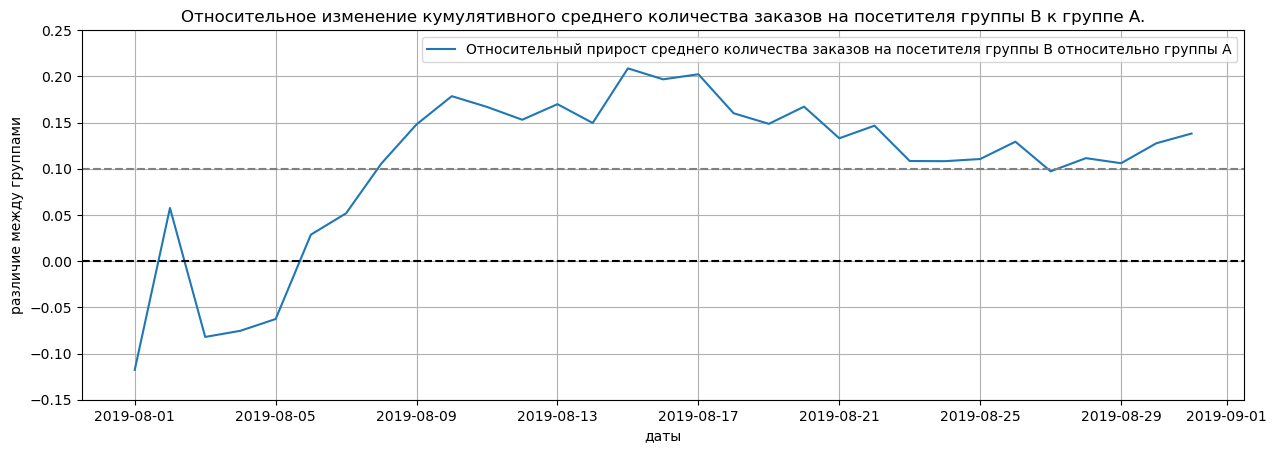

In [146]:
merged_cumulative_mean_orders = (
    cumulative_data_A[['date','mean_orders']]
    .merge(cumulative_data_B[['date','mean_orders']], left_on='date', right_on='date', how='left', suffixes=['_A', '_B'])
)

plt.figure().set_figwidth(15)
plt.plot(merged_cumulative_mean_orders['date'], 
         merged_cumulative_mean_orders['mean_orders_B']/merged_cumulative_mean_orders['mean_orders_A']-1, 
         label="Относительный прирост среднего количества заказов на посетителя группы B относительно группы A")
plt.legend()
plt.grid()
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A.')
plt.xlabel('даты')
plt.ylabel('различие между группами')

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.10, color='grey', linestyle='--')

plt.ylim(-0.15,0.25)
plt.show()

**Вывод:** почти с начала исследования группа В лидирует по кумулятивному среднему количеству заказов на посетителя. Становится лучше и лучше, после чего, вероятно зафиксировалась около прироста в 10% относительно группы А. Впрочем, сперва стоит поискать аномалии, возможно, они изменят картину.

### Количество заказов по пользователям.

In [28]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

orders_by_users.columns = ['user_id', 'orders']
orders_by_users.sort_values(by='orders', ascending=False).head(5)

,user_id,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


Перейдем к визуализации

#### Гистограмма.

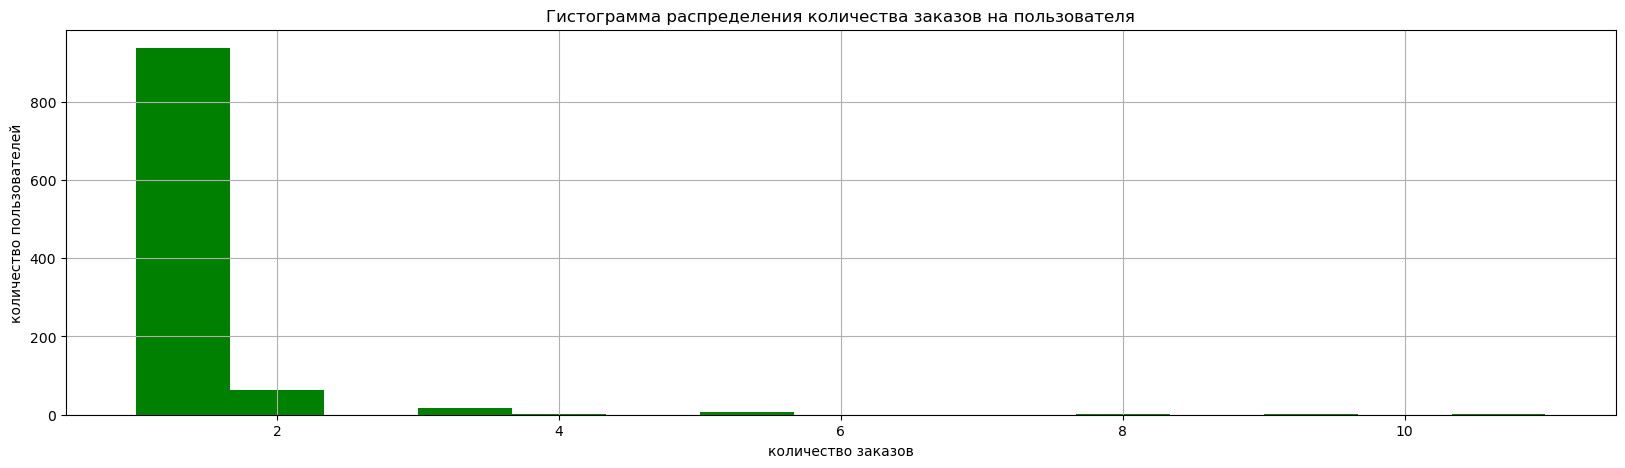

In [29]:
orders_by_users.hist(column='orders', bins=15,figsize=(20,5), color='green')

plt.title('Гистограмма распределения количества заказов на пользователя')
plt.xlabel('количество заказов')
plt.ylabel('количество пользователей')
plt.show()

#### Точечная диаграмма

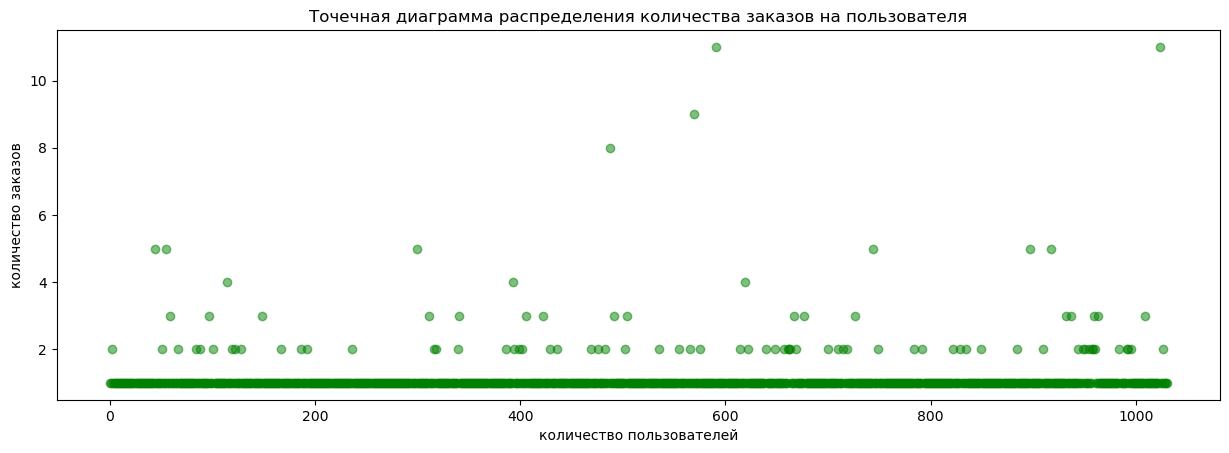

In [30]:
x_values = pd.Series(range(0,len(orders_by_users)))

plt.figure().set_figwidth(15)
plt.scatter(x_values, orders_by_users['orders'], alpha=0.5,color='green') 

plt.title('Точечная диаграмма распределения количества заказов на пользователя')
plt.xlabel('количество пользователей')
plt.ylabel('количество заказов')
plt.show()


**Вывод:** огромное количество пользователей совершали заказ всего один раз. Есть и определенная прослойка, совершавшая 2-3 заказа, их точная доля не ясна. Непонятно, считать их аномалиями или нет. Максимальное количество заказов на пользователя - 11. Это точно аномалия, однако проверим с помощью перцентилей.

#### 95-й и 99-й перцентили количества заказов на пользователя.

In [31]:
np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

**Вывод:** 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказа на пользователя, т.е, не более 5% пользователей совершали более 2-х заказов и не более 1% совершали более 4-х заказов.
Примем за аномальных пользователей тех, кто совершил от 5 заказов.


### Сумма чека по пользователям.

#### Гистограмма.

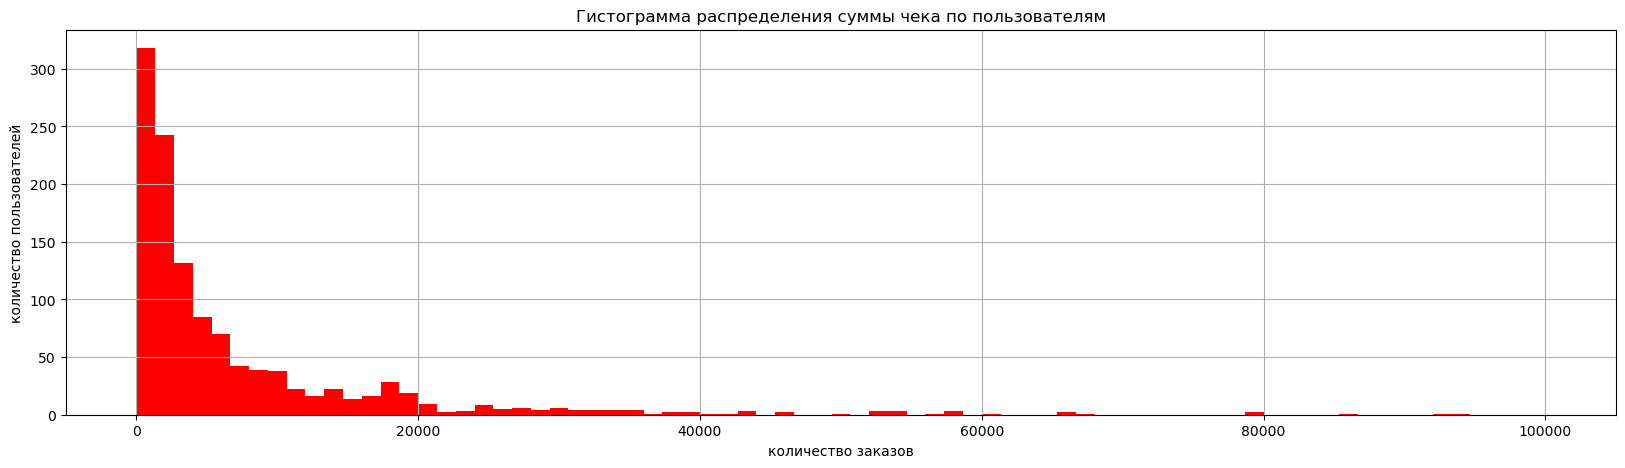

In [32]:
#устанавливаем range, чтобы детальнее посмотреть на распределение сумм. Сумму в 1,3 млн. мы увидим на след графике

orders.hist(column='revenue', bins=75, range=(0,100000) ,figsize=(20,5), color='red')


plt.title('Гистограмма распределения суммы чека по пользователям')
plt.xlabel('количество заказов')
plt.ylabel('количество пользователей')
plt.show()

#### Точечная диаграмма

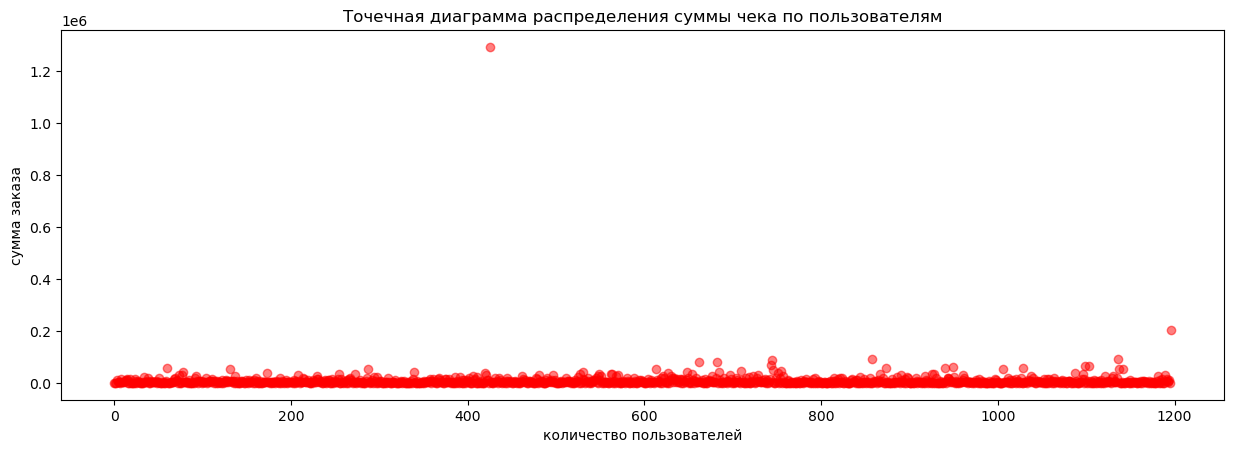

In [33]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure().set_figwidth(15)
plt.scatter(x_values, orders['revenue'], alpha=0.5, color='red')

plt.title('Точечная диаграмма распределения суммы чека по пользователям')
plt.xlabel('количество пользователей')
plt.ylabel('сумма заказа')
plt.show()

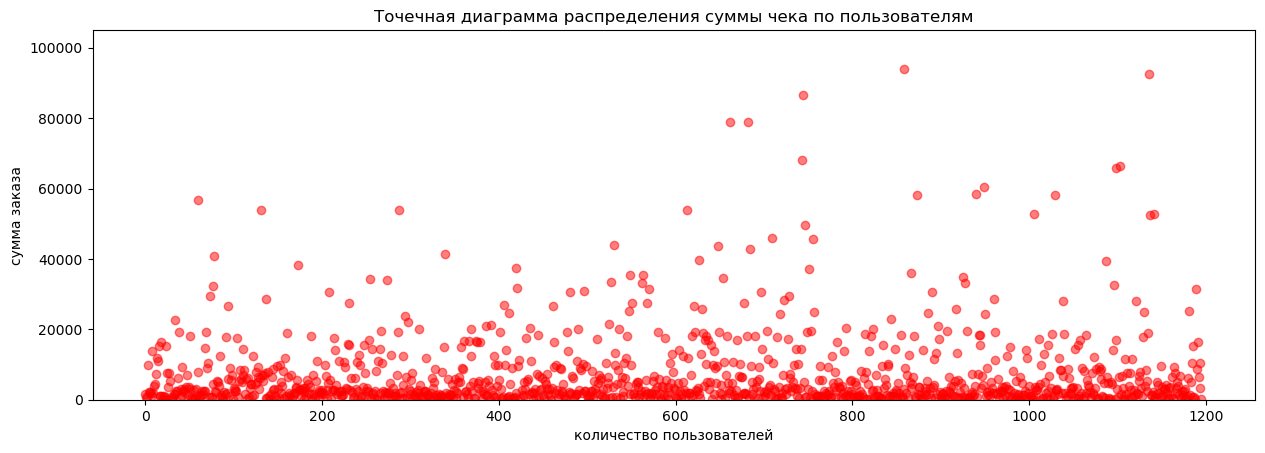

In [34]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure().set_figwidth(15)
plt.scatter(x_values, orders['revenue'], alpha=0.5, color='red')

plt.title('Точечная диаграмма распределения суммы чека по пользователям')
plt.xlabel('количество пользователей')
plt.ylabel('сумма заказа')
plt.ylim(0,105000)
plt.show()

**Вывод:** вот мы и нашли возможную причину резких скачков на кумулятивных графиках. Заказ почти в 1,3 млн.! Однозначно аномалия. Есть также заказ в районе 200 тыс. и определенное количество заказов от 100 до 160 тыс.

#### 95-й и 99-й перцентили суммы чека на пользователя.

In [35]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

**Вывод:** 95-й и 99-й перцентили стоимости суммы чека на пользователя равны 28 000 и 58 223 рублям, т.е, не более 5% пользователей совершали заказ на сумму свыше 28 000 руб. и не более 1% совершали заказ на сумму свыше 58 223 руб. Примем за аномальных пользователей тех, кто совершл заказ свыше 58 223 руб.

### Cтатистическая значимость.

#### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

Подготовим данные

In [36]:
visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']

visitors_A_cummulative = visitors_A_daily.apply(
    lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_A': 'sum'}
    ),
    axis=1,
)
visitors_A_cummulative.columns = ['date', 'visitors_cummulative_A']

visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']

visitors_B_cummulative = visitors_B_daily.apply(
    lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_B': 'sum'}
    ),
    axis=1,
)
visitors_B_cummulative.columns = ['date', 'visitors_cummulative_B']

orders_A_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_A_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

orders_A_cummulative = orders_A_daily.apply(
    lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_A': 'sum', 'revenue_per_date_A': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_A_cummulative.columns = [
    'date',
    'orders_cummulative_A',
    'revenue_cummulative_A',
]

orders_B_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_B_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

orders_B_cummulative = orders_B_daily.apply(
    lambda x: orders_B_daily[orders_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_B': 'sum', 'revenue_per_date_B': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_B_cummulative.columns = [
    'date',
    'orders_cummulative_B',
    'revenue_cummulative_B',
]

data = (
    orders_A_daily.merge(
        orders_B_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_B_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_A_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_B_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_B_cummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B,orders_cummulative_A,revenue_cummulative_A,orders_cummulative_B,revenue_cummulative_B,visitors_per_date_A,visitors_per_date_B,visitors_cummulative_A,visitors_cummulative_B
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Структура датафрейма `data`:

- `date` — дата;
- `orders_per_date_A` — количество заказов в выбранную дату в группе A;
- `revenue_per_date_A` — суммарная выручка в выбранную дату в группе A;
- `orders_per_date_B` — количество заказов в выбранную дату в группе B;
- `revenue_per_date_B` — суммарная выручка в выбранную дату в группе B;
- `orders_cummulative_A` — суммарное число заказов до выбранной даты включительно в группе A;
- `revenue_cummulative_A` — суммарная выручка до выбранной даты включительно в группе A;
- `orders_cummulative_B` — суммарное количество заказов до выбранной даты включительно в группе B;
- `revenue_cummulative_B` — суммарная выручка до выбранной даты включительно в группе B;
- `visitors_per_date_A` — количество пользователей в выбранную дату в группе A;
- `visitors_per_date_B` — количество пользователей в выбранную дату в группе B;
- `visitors_cummulative_A` — количество пользователей до выбранной даты включительно в группе A;
- `visitors_cummulative_B` — количество пользователей до выбранной даты включительно в группе B.

Сформулируем гипотезы:

- **Нулевая**: Статистически значимых различий в среднем количестве заказов между группами по "сырым" данным нет. 
- **Альтернативная**: Статистически значимые различия в среднем между группами по "сырым" данным есть. 

Уровень статистической значимости примем равный alpha = 0.05


Посчитаем статистическую значимость различия в среднем количестве заказов между группами.

Создадим переменные `orders_by_users_A` и `orders_by_users_B` со столбцами `['user_id', 'orders']`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

Объявим переменные `sample_A` и `sample_B`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [147]:
orders_by_users_A = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_A.columns = ['user_id', 'orders']

orders_by_users_B = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_B.columns = ['user_id', 'orders']

sample_A = pd.concat(
    [
        orders_by_users_A['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B = pd.concat(
    [
        orders_by_users_B['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [148]:
#создадим функцию, потому что сравнения в дальнейшем придется делать несколько раз.

def pvalue_stat (group_a, group_b):
    """
    функция для сравнения статистических различий
    
    """
    alpha = .05
    pvalue = stats.mannwhitneyu(group_a, group_b)[1]
    print('pvalue: {0:.3f}'.format(pvalue))
    if (pvalue < alpha):
          print('Отвергаем нулевую гипотезу')
    else:
          print('Не получилось отвергнуть нулевую гипотезу')
    print('Относительная разница:{0:.1%}'.format(group_b.mean() / group_a.mean() - 1))
           

In [149]:
pvalue_stat(sample_A, sample_B)

pvalue: 0.017
Отвергаем нулевую гипотезу
Относительная разница:13.8%


**Вывод:** pvalue меньше 0.05, нулевую гипотезу отвергаем. Анализ "сырых данных" сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный выигрыш группы B равен 13.8%

#### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Сформулируем гипотезы:

- **Нулевая**: Статистически значимых различий в среднем чеке между группами по "сырым" данным нет. 
- **Альтернативная**: Статистически значимые различия в среднем чеке между группами по "сырым" данным есть. 


Уровень статистической значимости также примем равный alpha = 0.05


Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию `mannwhitneyu()` данные о выручке с заказов. 
А ещё найдём относительные различия в среднем чеке между группами:


In [40]:
pvalue_stat(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])

pvalue: 0.729
Не получилось отвергнуть нулевую гипотезу
Относительная разница:25.9%


**Вывод:** pvalue значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. И это несмотря на то, что средний чек группы B значительно выше среднего чека группы A на 26%. Все дело в том, что мы применяем непараметрический тест Уилкоксона-Манна-Уитни `mannwhitneyu()`, он работает с рангами — номерами значений в упорядоченном ряду — никак не учитывая сами значения. Данный метод менее подвержен к выбросам.

#### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

Напомним, что найденные ранее 95-й и 99-й перцентили средних чеков равны 28 000 и 58 223 рублям. А 95-й и 99-й перцентили количества заказов на одного пользователя равны 2 и 4 заказазам на пользователя.
Примем за аномальных пользователей тех, кто совершил от 5 заказов или совершил заказ дороже 58 223 рублей. Так мы уберём 1% пользователей с наибольшим числом заказов и 1% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 4 — `users_with_many_orders` и пользователей, совершивших заказы дороже 58 223 — `users_with_expensive_orders`. Объединим их в таблице `abnormal_users`. 

Узнаем, сколько всего аномальных пользователей атрибутом `shape`.

In [168]:
users_with_many_orders = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['orders'] > np.percentile(orders_by_users['orders'], 99)]['user_id'],
        orders_by_users_B[orders_by_users_B['orders'] > np.percentile(orders_by_users['orders'], 99)]['user_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], 99)]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
    .reset_index()
)

print('Количество аномальных пользователей:', abnormal_users.shape[0])

Количество аномальных пользователей: 15


15 аномальных пользователей. Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по "очищенным данным". Подготовим данные для выборки количества заказов по пользователям по группам теста и посмотрим результаты:

In [42]:
sample_A_filtered = pd.concat(
    [
        orders_by_users_A[
            np.logical_not(orders_by_users_A['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B_filtered = pd.concat(
    [
        orders_by_users_B[
            np.logical_not(orders_by_users_B['user_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

pvalue_stat(sample_A_filtered, sample_B_filtered)

pvalue: 0.014
Отвергаем нулевую гипотезу
Относительная разница:15.3%


Сформулируем гипотезы:

- **Нулевая**: Статистически значимых различий в среднем количестве заказов между группами по "очищенным" данным нет. 
- **Альтернативная**: Статистически значимые различия в среднем между группами по "очищенным" данным есть. 

Уровень статистической значимости также примем равный alpha = 0.05


**Вывод:** pvalue на "очищенных данных" по-прежнему меньше 0.05, нулевую гипотезу отвергаем. Анализ "очищенных данных" также сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный выигрыш группы B увеличился с 13.8% до 15.3% Проверим, произошло ли что-нибудь с результатами по среднему чеку?

#### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Сформулируем гипотезы:

- **Нулевая**: Статистически значимых различий в среднем чеке между группами по "очищенным" данным нет. 
- **Альтернативная**: Статистически значимые различия в среднем чеке между группами по "очищенным" данным есть. 
    
    
Уровень статистической значимости равный alpha = 0.05

In [43]:
pvalue_stat(
    orders[(orders['group']=='A') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue'], 
    orders[(orders['group']=='B') & np.logical_not(orders['visitor_id'].isin(abnormal_users))]['revenue']
                  )

pvalue: 0.851
Не получилось отвергнуть нулевую гипотезу
Относительная разница:-0.6%


Напомним, на "сырых данных" были следующие показатели:

- pvalue: 0.729
- Не получилось отвергнуть нулевую гипотезу
- Относительная разница:25.9%

**Вывод:** что мы видим на "очищенных данных" - pvalue увеличился, но разница между сегментами сократилась до такой степени, что образовался относительный не большой проигрыш группы В, равный 0.6%, т.е разницы по среднему чеку между группами практически нет. Хотя общие выводы по результатам теста не изменились. Такой пример хорошо показывает, как сильно аномалии могут влиять на результаты A/B-теста, заказ в 1.3 млн. не мог не сказаться.


### Общий вывод.

В ходе нашего исследования мы проанализировали список гипотез для увеличения выручки, подготовленный совместно с отделом маркетинга.
* Выделили топ-5 гипотез:
    * Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
    * Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
    * Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
    * Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
    * Запустить акцию, дающую скидку на товар в день рождения

Эти гипотезы имеют средние или не большие затраты для проверки, хорошее влияние на пользователей, их опыт и удовлетворение от продукта. Либо мы имеем высокую уверенность что эти изменения повлияют на пользователей именно так, как мы предполагаем.

В части анализа А/В-теста.

* А/В-тест длился 30 дней;
* всего поучаствовало в тесте за это время 37,6 тысяч пользователей;
* осуществлено было 1197 заказов

Среди покупателей имеются аномальные значения, в частности:
* более 4 заказов одного пользователя за тестируемый период - не более 1%;
* заказы свыше 58 223 руб. - не более 1%
 
 
Статистическая значимость была определена следующим образом:
* в среднем количестве заказов на посетителя между группами по «сырым» данным относительная разница в пользу группы В - 13,8%
* в среднем количестве заказов на посетителя между группами между группами по «очищенным» данным в пользу группы В - 15,3%


* в среднем чеке заказа между группами по «сырым» данным в пользу группы В - 25,9%
* в среднем чеке заказа между группами по «очищенным» данным в пользу группы А - 0,6%

Таким образом, мы можем сделать вывод, что несмотря на то, что сумма среднего чека заказа осталась практически неизменной, среднее количество заказов у группы В увеличилось по отношению к группе А на 13-15%. Исходя из итого, мы принимаем решение остановить тест и зафиксировать победу группы В.